# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, shutil
from glob import glob
from PIL import Image
from tqdm import tqdm_notebook

# Split data to train, validation and test

## Make directories for train, validation and test

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to the directory containing all images
image_dir = os.path.join("data","HAM10000_images")

# Path to the CSV file containing image labels
metadata_path = os.path.join("data","HAM10000_metadata.csv")

# Directories for the split datasets
train_dir = 'train'
test_dir = 'test'
validation_dir = 'valid'

# Creating directories if they don't exist
for directory in [train_dir, test_dir, validation_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)


## Assign labels

- 1: Presence of melanoma
- 0: Absence of melanoma

In [3]:
import pandas as pd

# Load metadata
metadata = pd.read_csv(metadata_path)

target=list(map(lambda x: 1 if x=='mel' else 0,metadata['dx']))
metadata['target']=target
print(metadata)
# Splitting the dataset into train, validation, and test sets
train_val, test = train_test_split(metadata, test_size=0.2, random_state=42)
train, validation = train_test_split(train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


         lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

       target  
0           0  
1           0  
2           0  

## Move images to respective directories

In [6]:
def move_images(df, source_dir, target_dir):
    for _, row in tqdm_notebook(df.iterrows()):
        filename = row['image_id'] + '.jpg'  # Assuming image IDs in the CSV and filenames match
        source_path = os.path.join(source_dir, filename)
        target_path = os.path.join(target_dir, filename)
        
        # Move the image
        if os.path.exists(target_path) is False:
            shutil.move(source_path, target_path)

# Moving the images
move_images(train, image_dir, train_dir)
move_images(validation, image_dir, validation_dir)
move_images(test, image_dir, test_dir)


C:\Users\satiy\AppData\Local\Temp\ipykernel_3188\897888872.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, row in tqdm_notebook(df.iterrows()):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Append the target labels to images

In [7]:
import os
train_images = [f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))]
test_images = [f for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f))]
validation_images = [f for f in os.listdir(validation_dir) if os.path.isfile(os.path.join(validation_dir, f))]


In [8]:
def append_target_to_images(images):    
    metadata_dict = pd.Series(metadata['dx'].values,index=metadata['image_id']).to_dict()
    images_with_target = []
    for image in images:
        image_id = image.split('.')[0]  # Assuming image_id does not contain '.'
        target = 1 if metadata_dict.get(image_id) == 'mel' else 0
        train_image_with_label=(image,target)
        images_with_target.append(train_image_with_label)
    return images_with_target



In [9]:
train_images_with_targets=append_target_to_images(train_images)
test_images_with_targets=append_target_to_images(test_images)
validation_images_with_targets=append_target_to_images(validation_images)

# Display counts of melanoma and non-melanoma images.

In [10]:
melanoma_count_in_train=sum(map(lambda x:x[1],train_images_with_targets))
melanoma_count_in_test=sum(map(lambda x:x[1],test_images_with_targets))
melanoma_count_in_validation=sum(map(lambda x:x[1],validation_images_with_targets))

In [11]:
print(f"Count of people with melanoma in train_images_with_targets:{melanoma_count_in_train}")
print(f"Count of people without melanoma in train_images_with_targets:{len(train_images_with_targets)-melanoma_count_in_train}")

Count of people with melanoma in train_images_with_targets:657
Count of people without melanoma in train_images_with_targets:5352


In [12]:
print(f"Count of people with melanoma in test_images_with_targets:{melanoma_count_in_test}")
print(f"Count of people without melanoma in test_images_with_targets:{len(test_images_with_targets)-melanoma_count_in_test}")

Count of people with melanoma in test_images_with_targets:226
Count of people without melanoma in test_images_with_targets:1777


In [13]:
print(f"Count of people with melanoma in validation_images_with_targets:{melanoma_count_in_validation}")
print(f"Count of people without melanoma in validation_images_with_targets:{len(validation_images_with_targets)-melanoma_count_in_validation}")

Count of people with melanoma in validation_images_with_targets:230
Count of people without melanoma in validation_images_with_targets:1773


## Move the images to melanoma/non-melanoma directories.

We move the images based on presence of melanoma to sub-directories "mel" or "no_mel" existing within the train, validation and test folders.

In [14]:
import os

def move_on_class(imagelist,dirs):
    for image_name, label in tqdm_notebook(imagelist):
        mel_dir = os.path.join(dirs, 'mel')
        no_mel_dir = os.path.join(dirs, 'no_mel')
        os.makedirs(mel_dir, exist_ok=True)
        os.makedirs(no_mel_dir, exist_ok=True)
        source_dir=dirs
        # Determine the source path of the image
        source_path = os.path.join(source_dir, image_name)

        # Determine the destination path based on the label
        if label == 1:  # Melanoma
            dest_path = os.path.join(mel_dir, image_name)
        else:  # Non-melanoma
            dest_path = os.path.join(no_mel_dir, image_name)
            

        # Move the image from source to destination
        shutil.move(source_path, dest_path)



In [16]:
move_on_class(train_images_with_targets,'train')

C:\Users\satiy\AppData\Local\Temp\ipykernel_3188\1598080054.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image_name, label in tqdm_notebook(imagelist):


  0%|          | 0/6009 [00:00<?, ?it/s]

In [17]:
move_on_class(test_images_with_targets,'test')

C:\Users\satiy\AppData\Local\Temp\ipykernel_3188\1598080054.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image_name, label in tqdm_notebook(imagelist):


  0%|          | 0/2003 [00:00<?, ?it/s]

In [18]:
move_on_class(validation_images_with_targets,'valid')

C:\Users\satiy\AppData\Local\Temp\ipykernel_3188\1598080054.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image_name, label in tqdm_notebook(imagelist):


  0%|          | 0/2003 [00:00<?, ?it/s]

# Image Transformations

## Add Gaussian Noise

In [2]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random brightness and contrast changes
    transforms.RandomRotation(degrees=20),  # Random rotation up to 20 degrees
    transforms.RandomPerspective(distortion_scale=0.5),  # Random perspective transform
    transforms.GaussianBlur(kernel_size=3),  # Random Gaussian blur
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1)], p=0.5),  # Random brightness change
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor
])

# Create dataloaders

In [5]:
from torchvision import datasets
from torch.utils.data import DataLoader
# Create datasets using ImageFolder

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(root=validation_dir, transform=transform)

# Create data loaders
batch_size =12  # Set this to something appropriate for your hardware

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(train_loader)

In [6]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of batches in train_loader: {len(train_loader)}")


Number of training samples: 6009
Number of batches in train_loader: 501


In [7]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")





CUDA is available. Using GPU.


# Train Model

## Load model backbone

In [8]:
from torchvision import models

# Load the pre-trained DenseNet201 and MobileNetV2 models
densenet = models.densenet201(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)


C:\Users\satiy\anaconda3\envs\dl_test\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\satiy\anaconda3\envs\dl_test\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\satiy\anaconda3\envs\dl_test\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights

## Fine-tune model

In [9]:
import torch
# DenseNet201: Replace classifier with an identity layer to keep features
densenet.classifier = torch.nn.Identity()

# MobileNetV2: Replace classifier with an identity layer as well
mobilenet.classifier = torch.nn.Identity()


### Create custom classification head

Our fine-tuned model will be the _CombinedModel_ class. The _CombinedModel_ class leverages a _CustomClassificationHead_ class to make predictions.

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.checkpoint import checkpoint
import torch.nn.utils.prune as prune


class CustomClassificationHead(nn.Module):
    def __init__(self, num_features, num_classes):
        super(CustomClassificationHead, self).__init__()
        # No changes here as this part is not as memory intensive
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.batch_norm = nn.BatchNorm1d(num_features)
        self.dense1 = nn.Linear(num_features, 512)  # Consider reducing size if necessary
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(512, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the features
        x = self.batch_norm(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.log_softmax(x)
        return x

class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        densenet = models.densenet201(pretrained=True)
        mobilenet = models.mobilenet_v2(pretrained=True)
        
        # Remove classification layers
        densenet.classifier = nn.Identity()
        mobilenet.classifier = nn.Sequential(*list(mobilenet.classifier.children())[:-1], nn.Identity())
        
        self.densenet = densenet
        self.mobilenet = mobilenet
        
        # Feature reduction layer
        self.feature_reduction = nn.Linear(1920 + 1280, 1024)  # Example: Reducing to 1024 features
        
        # Adjusted classification head for reduced feature size
        self.classification_head = CustomClassificationHead(num_features=1024, num_classes=2)

    def forward(self, x):
        # Using checkpointing for memory efficiency
        features_densenet = checkpoint(self.densenet, x)
        features_mobilenet = checkpoint(self.mobilenet, x)
        
        # Concatenate features along the feature dimension
        features_combined = torch.cat((features_densenet, features_mobilenet), dim=1)
        
        # Reduce feature size
        reduced_features = self.feature_reduction(features_combined)
        
        # Forward pass through the classification head
        x = self.classification_head(reduced_features)
        return x

# Initialize the combined model
combined_model = CombinedModel()

# Assuming 'device' is defined (e.g., cuda or cpu)
combined_model=combined_model.to(device)


# Example: Pruning 20% of connections in the dense1 layer of the classification head by weight magnitude
prune.l1_unstructured(combined_model.classification_head.dense1, name='weight', amount=0.2)


Linear(in_features=1024, out_features=512, bias=True)

## Testing data-loader objects created above.

In [11]:
import torch

torch.cuda.empty_cache()  # Clear unused memory

inputs, labels = next(iter(train_loader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = combined_model(inputs)  # Check if this line hangs

C:\Users\satiy\anaconda3\envs\dl_test\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\satiy\anaconda3\envs\dl_test\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [12]:
optimizer = torch.optim.AdamW(combined_model.parameters(), lr=0.001, weight_decay=0.01)
criterion = torch.nn.NLLLoss()

In [13]:
if (os.path.exists("models") is False):
    os.makedirs("models")

In [14]:
os.path.exists("models")

True

## Model Training

Within model training, we will:
- Cache the model checkpoint every 10 epochs
- Store the checkpointed models to the "models" folder.
- Plot them

C:\Users\satiy\AppData\Local\Temp\ipykernel_21564\3414649818.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm_notebook(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):


Epoch 1/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:27<00:00,  6.15it/s]

Epoch 1: Train Loss: 0.3084, Train Acc: 88.52%, Valid Loss: 0.2749, Valid Acc: 89.12%


Epoch 2/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.05it/s]

Epoch 2: Train Loss: 0.2838, Train Acc: 89.02%, Valid Loss: 0.2666, Valid Acc: 88.62%


Epoch 3/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:52<00:00,  3.19it/s]

Epoch 3: Train Loss: 0.2853, Train Acc: 89.07%, Valid Loss: 0.2726, Valid Acc: 88.72%


Epoch 4/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.04it/s]

Epoch 4: Train Loss: 0.2775, Train Acc: 89.52%, Valid Loss: 0.2924, Valid Acc: 86.57%


Epoch 5/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.11it/s]

Epoch 5: Train Loss: 0.2762, Train Acc: 89.67%, Valid Loss: 0.2851, Valid Acc: 88.57%


Epoch 6/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.13it/s]

Epoch 6: Train Loss: 0.2686, Train Acc: 89.30%, Valid Loss: 0.2495, Valid Acc: 89.77%


Epoch 7/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:55<00:00,  3.04it/s]

Epoch 7: Train Loss: 0.2603, Train Acc: 89.60%, Valid Loss: 0.2548, Valid Acc: 89.32%


Epoch 8/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.09it/s]

Epoch 8: Train Loss: 0.2565, Train Acc: 89.75%, Valid Loss: 0.2550, Valid Acc: 89.37%


Epoch 9/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.10it/s]

Epoch 9: Train Loss: 0.2522, Train Acc: 89.88%, Valid Loss: 0.2620, Valid Acc: 89.82%


Epoch 10/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:51<00:00,  3.26it/s]


Epoch 10: Train Loss: 0.2680, Train Acc: 89.50%, Valid Loss: 0.2527, Valid Acc: 89.67%
Saved model checkpoint at epoch 10


Epoch 11/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:52<00:00,  3.15it/s]

Epoch 11: Train Loss: 0.2522, Train Acc: 89.90%, Valid Loss: 0.2462, Valid Acc: 89.77%


Epoch 12/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:49<00:00,  3.35it/s]

Epoch 12: Train Loss: 0.2474, Train Acc: 90.13%, Valid Loss: 0.2460, Valid Acc: 89.97%


Epoch 13/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.13it/s]

Epoch 13: Train Loss: 0.2496, Train Acc: 89.93%, Valid Loss: 0.2501, Valid Acc: 89.57%


Epoch 14/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.13it/s]

Epoch 14: Train Loss: 0.2496, Train Acc: 89.83%, Valid Loss: 0.2480, Valid Acc: 90.31%


Epoch 15/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.07it/s]

Epoch 15: Train Loss: 0.2475, Train Acc: 90.03%, Valid Loss: 0.2503, Valid Acc: 90.61%


Epoch 16/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:52<00:00,  3.17it/s]

Epoch 16: Train Loss: 0.2505, Train Acc: 90.23%, Valid Loss: 0.2473, Valid Acc: 89.37%


Epoch 17/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:51<00:00,  3.24it/s]

Epoch 17: Train Loss: 0.2483, Train Acc: 90.28%, Valid Loss: 0.2683, Valid Acc: 88.87%


Epoch 18/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:51<00:00,  3.22it/s]

Epoch 18: Train Loss: 0.2473, Train Acc: 90.00%, Valid Loss: 0.2710, Valid Acc: 89.07%


Epoch 19/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:51<00:00,  3.23it/s]

Epoch 19: Train Loss: 0.2481, Train Acc: 90.18%, Valid Loss: 0.2466, Valid Acc: 89.77%


Epoch 20/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:52<00:00,  3.21it/s]


Epoch 20: Train Loss: 0.2442, Train Acc: 89.95%, Valid Loss: 0.2597, Valid Acc: 90.01%
Saved model checkpoint at epoch 20


Epoch 21/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:51<00:00,  3.22it/s]

Epoch 21: Train Loss: 0.2461, Train Acc: 90.05%, Valid Loss: 0.2438, Valid Acc: 89.82%


Epoch 22/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:51<00:00,  3.24it/s]

Epoch 22: Train Loss: 0.2443, Train Acc: 90.41%, Valid Loss: 0.2469, Valid Acc: 89.92%


Epoch 23/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:50<00:00,  3.28it/s]

Epoch 23: Train Loss: 0.2437, Train Acc: 90.36%, Valid Loss: 0.2510, Valid Acc: 90.26%


Epoch 24/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:51<00:00,  3.22it/s]

Epoch 24: Train Loss: 0.2416, Train Acc: 90.00%, Valid Loss: 0.2513, Valid Acc: 90.31%


Epoch 25/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:52<00:00,  3.21it/s]

Epoch 25: Train Loss: 0.2425, Train Acc: 90.30%, Valid Loss: 0.2469, Valid Acc: 90.11%


Epoch 26/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:51<00:00,  3.22it/s]

Epoch 26: Train Loss: 0.2411, Train Acc: 90.30%, Valid Loss: 0.2574, Valid Acc: 89.52%


Epoch 27/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:50<00:00,  3.28it/s]

Epoch 27: Train Loss: 0.2424, Train Acc: 90.35%, Valid Loss: 0.2499, Valid Acc: 89.92%


Epoch 28/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.12it/s]

Epoch 28: Train Loss: 0.2376, Train Acc: 90.18%, Valid Loss: 0.2499, Valid Acc: 89.97%


Epoch 29/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.05it/s]

Epoch 29: Train Loss: 0.2424, Train Acc: 90.43%, Valid Loss: 0.2452, Valid Acc: 90.11%


Epoch 30/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.10it/s]


Epoch 30: Train Loss: 0.2459, Train Acc: 90.06%, Valid Loss: 0.2464, Valid Acc: 89.77%
Saved model checkpoint at epoch 30


Epoch 31/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.07it/s]

Epoch 31: Train Loss: 0.2415, Train Acc: 90.10%, Valid Loss: 0.2323, Valid Acc: 90.76%


Epoch 32/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:56<00:00,  2.94it/s]

Epoch 32: Train Loss: 0.2318, Train Acc: 90.45%, Valid Loss: 0.2506, Valid Acc: 89.37%


Epoch 33/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.05it/s]

Epoch 33: Train Loss: 0.2410, Train Acc: 90.05%, Valid Loss: 0.2567, Valid Acc: 89.47%


Epoch 34/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.07it/s]

Epoch 34: Train Loss: 0.2354, Train Acc: 90.20%, Valid Loss: 0.2447, Valid Acc: 89.47%


Epoch 35/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.09it/s]

Epoch 35: Train Loss: 0.2317, Train Acc: 90.60%, Valid Loss: 0.2340, Valid Acc: 90.26%


Epoch 36/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.13it/s]

Epoch 36: Train Loss: 0.2319, Train Acc: 90.60%, Valid Loss: 0.2371, Valid Acc: 90.66%


Epoch 37/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.10it/s]

Epoch 37: Train Loss: 0.2329, Train Acc: 90.53%, Valid Loss: 0.2472, Valid Acc: 89.57%


Epoch 38/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.13it/s]

Epoch 38: Train Loss: 0.2352, Train Acc: 90.58%, Valid Loss: 0.2258, Valid Acc: 90.86%


Epoch 39/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.14it/s]

Epoch 39: Train Loss: 0.2330, Train Acc: 90.13%, Valid Loss: 0.2511, Valid Acc: 89.92%


Epoch 40/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.15it/s]


Epoch 40: Train Loss: 0.2304, Train Acc: 90.78%, Valid Loss: 0.2446, Valid Acc: 90.31%
Saved model checkpoint at epoch 40


Epoch 41/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.15it/s]

Epoch 41: Train Loss: 0.2356, Train Acc: 90.50%, Valid Loss: 0.2391, Valid Acc: 90.51%


Epoch 42/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.11it/s]

Epoch 42: Train Loss: 0.2337, Train Acc: 90.38%, Valid Loss: 0.2444, Valid Acc: 90.21%


Epoch 43/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.06it/s]

Epoch 43: Train Loss: 0.2373, Train Acc: 90.60%, Valid Loss: 0.2423, Valid Acc: 89.92%


Epoch 44/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.05it/s]

Epoch 44: Train Loss: 0.2383, Train Acc: 90.50%, Valid Loss: 0.2485, Valid Acc: 90.41%


Epoch 45/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.06it/s]

Epoch 45: Train Loss: 0.2322, Train Acc: 90.20%, Valid Loss: 0.2373, Valid Acc: 89.47%


Epoch 46/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.09it/s]

Epoch 46: Train Loss: 0.2331, Train Acc: 90.68%, Valid Loss: 0.2436, Valid Acc: 90.41%


Epoch 47/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.13it/s]

Epoch 47: Train Loss: 0.2258, Train Acc: 90.98%, Valid Loss: 0.2432, Valid Acc: 89.62%


Epoch 48/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.12it/s]

Epoch 48: Train Loss: 0.2307, Train Acc: 90.83%, Valid Loss: 0.2322, Valid Acc: 90.11%


Epoch 49/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.13it/s]

Epoch 49: Train Loss: 0.2313, Train Acc: 90.98%, Valid Loss: 0.2444, Valid Acc: 90.01%


Epoch 50/50 - Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.14it/s]


Epoch 50: Train Loss: 0.2321, Train Acc: 90.50%, Valid Loss: 0.2306, Valid Acc: 90.36%
Saved model checkpoint at epoch 50


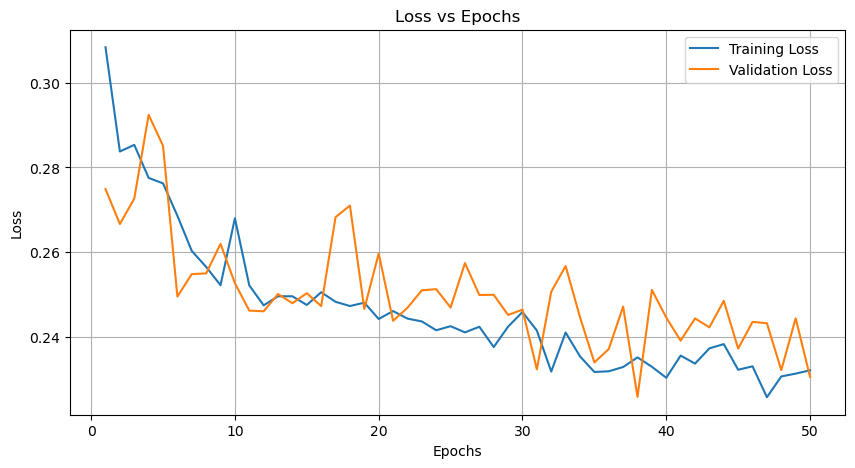

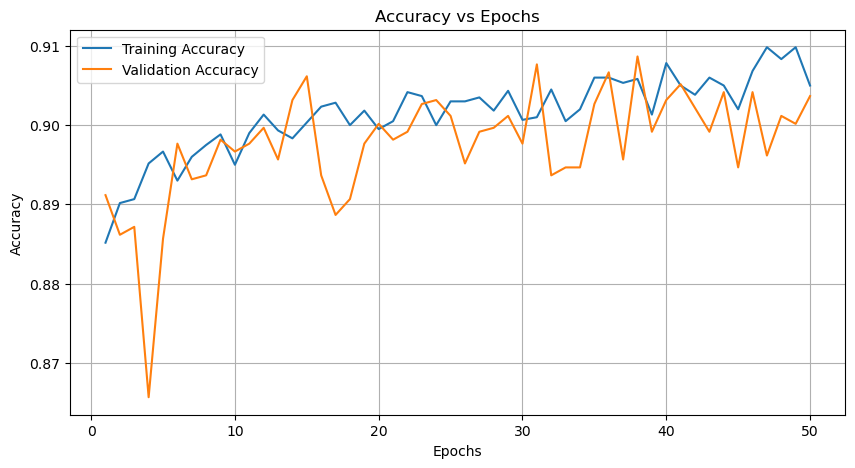

In [15]:
from tqdm import tqdm

epochs = 50

if os.path.exists("models") is False:
    os.makedirs("models")

# store the losses and accuracies
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in range(epochs):
    combined_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm_notebook(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = combined_model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = correct / total
    
    # Validation phase
    combined_model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = combined_model(inputs)
            loss = criterion(outputs, labels)
            
            valid_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    valid_accuracy = correct / total

    train_losses.append(running_loss / len(train_loader))
    valid_losses.append(valid_loss / len(valid_loader))
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    
    
    print(f"Epoch {epoch+1}: Train Loss: {running_loss / len(train_loader):.4f}, "
          f"Train Acc: {train_accuracy * 100:.2f}%, "
          f"Valid Loss: {valid_loss / len(valid_loader):.4f}, "
          f"Valid Acc: {valid_accuracy * 100:.2f}%")

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(combined_model.state_dict(), os.path.join('models', f'combined_model_epoch_{epoch+1}.pth'))
        print(f"Saved model checkpoint at epoch {epoch+1}")


# Plot loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy against epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Model Evaluation

## Load checkpointed models

In [16]:
combined_model = CombinedModel().to(device)
prune.l1_unstructured(combined_model.classification_head.dense1, name='weight', amount=0.2)  # Reapply pruning
combined_model.load_state_dict(torch.load(os.path.join('models', f'combined_model_epoch_50.pth')))

<All keys matched successfully>

## Run Testing

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Directory for the test dataset
test_dir = 'test'

# Create test dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create data loader for test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Initialize lists to store predictions and ground truth labels
all_predictions = []
all_labels = []

# Set the model to evaluation mode
combined_model.eval()

# Iterate over test data
for inputs, labels in tqdm_notebook(test_loader, desc="Testing"):
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Forward pass
    outputs = combined_model(inputs)
    
    # Get predictions
    _, predicted = torch.max(outputs, 1)
    
    # Append predictions and labels to lists
    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)

# Calculate precision
test_precision = precision_score(all_labels, all_predictions)

# Calculate recall
test_recall = recall_score(all_labels, all_predictions)

# Calculate F1 score
test_f1_score = f1_score(all_labels, all_predictions)

# Print results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

C:\Users\satiy\AppData\Local\Temp\ipykernel_21564\3158632638.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm_notebook(test_loader, desc="Testing"):


Testing:   0%|          | 0/167 [00:00<?, ?it/s]

Confusion Matrix:
[[  55  171]
 [  23 1754]]
Test Accuracy: 0.9031
Test Precision: 0.9112
Test Recall: 0.9871
Test F1 Score: 0.9476
